In [1]:
%%time
# Purpose: Comparing global ocean heat content changes from my new IAF
#          simulation to the observations in Cheng et al., 2016 [IAP, China]
#          and EN4 (Gouretski & Reseghetti, 2010; Levitus et al., 2009)
#          -> http://ddl.escience.cn/f/FiL0 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 18. 05. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m


#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "

from dask.distributed import Client
client = Client(n_workers=4)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]
# Wall time: 1min 15s

CPU times: user 4.52 s, sys: 4.17 s, total: 8.69 s
Wall time: 26.2 s


### Load in last cycle total_ocean_heat from the 1° runs by Hakase

CPU times: user 18.4 s, sys: 1.8 s, total: 20.2 s
Wall time: 32.7 s


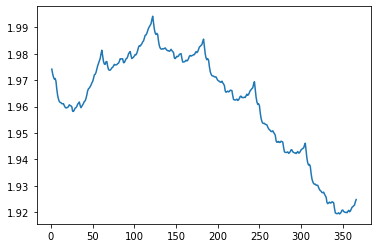

In [2]:
%%time
# # ------------------------------------------------------------------------------------- # #
### Load in 1deg IAF SPIN-UP FROM HAKASE HAYASHIDA
# # ------------------------------------------------------------------------------------- # #
base_omip = '/g/data/ik11/outputs/access-om2/' # read in the new omip simulations from ryan

a = ['%03d' % i for i in np.linspace(183,243,61)]
aa = ['%03d' % i for i in np.linspace(244,304,61)]
aaa = ['%03d' % i for i in np.linspace(305,365,61)]
b = ['%03d' % i for i in np.linspace(0,60,61)]
bb = ['%03d' % i for i in np.linspace(61,121,61)]
bbb = ['%03d' % i for i in np.linspace(122,182,61)]
# empty list which I fill up each iteration    
c = []; cc = []; ccc = []; f = []; ff = []; fff = []; 

for i in range(61): # loop through the number of files I would like to open
    c.append(i); cc.append(i); ccc.append(i) # append the list
    f.append(i); ff.append(i); fff.append(i)
    c[i] = base_omip + '1deg_jra55_iaf_omip2_cycle4/output' + a[i] + '/ocean/ocean_scalar.nc'
    cc[i] = base_omip + '1deg_jra55_iaf_omip2_cycle5/output' + aa[i] + '/ocean/ocean_scalar.nc'
    ccc[i] = base_omip + '1deg_jra55_iaf_omip2_cycle6/output' + aaa[i] + '/ocean/ocean_scalar.nc'
    f[i] = base_omip + '1deg_jra55_iaf_omip2_cycle1/output' + b[i] + '/ocean/ocean_scalar.nc'
    ff[i] = base_omip + '1deg_jra55_iaf_omip2_cycle2/output' + bb[i] + '/ocean/ocean_scalar.nc'
    fff[i] = base_omip + '1deg_jra55_iaf_omip2_cycle3/output' + bbb[i] + '/ocean/ocean_scalar.nc'
    
# open all the files which are part of the list
OHC_1deg_c4 = xr.open_mfdataset(c,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_1deg_c5 = xr.open_mfdataset(cc,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_1deg_c6 = xr.open_mfdataset(ccc,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_1deg_c1 = xr.open_mfdataset(f,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_1deg_c2 = xr.open_mfdataset(ff,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_1deg_c3 = xr.open_mfdataset(fff,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()

OHC_1deg = np.empty([183, 2])
OHC_1deg[:,0] = np.linspace(1,183,183)
OHC_1deg[0:61,1] = OHC_1deg_c4; OHC_1deg[61:122,1] = OHC_1deg_c5; OHC_1deg[122:183,1] = OHC_1deg_c6 # write data into data frame

OHC_1deg_full = np.empty([366, 2])
OHC_1deg_full[:,0] = np.linspace(1,366,366)
OHC_1deg_full[0:61,1] = OHC_1deg_c1
OHC_1deg_full[61:122,1] = OHC_1deg_c2; 
OHC_1deg_full[122:183,1] = OHC_1deg_c3
OHC_1deg_full[183:244,1] = OHC_1deg_c4
OHC_1deg_full[244:305,1] = OHC_1deg_c5; 
OHC_1deg_full[305:366,1] = OHC_1deg_c6 # write data into data frame
plt.plot(OHC_1deg_full[:,0],OHC_1deg_full[:,1])
# Wall time: 

### Load in last cycle total_ocean_heat from the 1/4° runs by Ryan

CPU times: user 17.4 s, sys: 1.63 s, total: 19 s
Wall time: 26.3 s


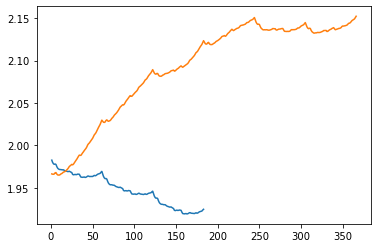

In [3]:
%%time
# # ------------------------------------------------------------------------------------- # #
### Load in 025deg IAF SPIN-UP FROM RYAN HOLMES
# # ------------------------------------------------------------------------------------- # #
base_omip = '/g/data/ik11/outputs/access-om2-025/' # read in the new omip simulations from ryan

a = ['%03d' % i for i in np.linspace(183,243,61)]
aa = ['%03d' % i for i in np.linspace(244,304,61)]
aaa = ['%03d' % i for i in np.linspace(305,365,61)]
b = ['%03d' % i for i in np.linspace(0,60,61)]
bb = ['%03d' % i for i in np.linspace(61,121,61)]
bbb = ['%03d' % i for i in np.linspace(122,182,61)]

# empty list which I fill up each iteration    
c = []; cc = []; ccc = []; f = []; ff = []; fff = [] 
for i in range(61): # loop through the number of files I would like to open
    c.append(i); cc.append(i); ccc.append(i) # append the list
    f.append(i); ff.append(i); fff.append(i)
    c[i] = base_omip + '025deg_jra55_iaf_omip2_cycle4/output' + a[i] + '/ocean/ocean_scalar.nc'
    cc[i] = base_omip + '025deg_jra55_iaf_omip2_cycle5/output' + aa[i] + '/ocean/ocean_scalar.nc'
    ccc[i] = base_omip + '025deg_jra55_iaf_omip2_cycle6/output' + aaa[i] + '/ocean/ocean_scalar.nc'
    f[i] = base_omip + '025deg_jra55_iaf_omip2_cycle1/output' + b[i] + '/ocean/ocean_scalar.nc'
    ff[i] = base_omip + '025deg_jra55_iaf_omip2_cycle2/output' + bb[i] + '/ocean/ocean_scalar.nc'
    fff[i] = base_omip + '025deg_jra55_iaf_omip2_cycle3/output' + bbb[i] + '/ocean/ocean_scalar.nc'

# open all the files which are part of the list
OHC_025deg_c4 = xr.open_mfdataset(c,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_025deg_c5 = xr.open_mfdataset(cc,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_025deg_c6 = xr.open_mfdataset(ccc,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_025deg_c1 = xr.open_mfdataset(f,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_025deg_c2 = xr.open_mfdataset(ff,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()
OHC_025deg_c3 = xr.open_mfdataset(fff,decode_times = True).total_ocean_heat.groupby('time.year').mean('time').drop('scalar_axis').squeeze().load()

OHC_025deg = np.empty([183, 2])
OHC_025deg[:,0] = np.linspace(1,183,183)
OHC_025deg[0:61,1] = OHC_025deg_c4; OHC_025deg[61:122,1] = OHC_025deg_c5; OHC_025deg[122:183,1] = OHC_025deg_c6 # write data into data frame
plt.plot(OHC_1deg[:,0], OHC_1deg[:,1], label='ACCESS-OM2-1')
# plt.plot(OHC_025deg[:,0], OHC_025deg[:,1],label='ACCESS-OM2-025'); plt.legend()

OHC_025deg_full = np.empty([366, 2])
OHC_025deg_full[:,0] = np.linspace(1,366,366)
OHC_025deg_full[0:61,1] = OHC_025deg_c1
OHC_025deg_full[61:122,1] = OHC_025deg_c2; 
OHC_025deg_full[122:183,1] = OHC_025deg_c3
OHC_025deg_full[183:244,1] = OHC_025deg_c4
OHC_025deg_full[244:305,1] = OHC_025deg_c5 
OHC_025deg_full[305:366,1] = OHC_025deg_c6 # write data into data frame
plt.plot(OHC_025deg_full[:,0],OHC_025deg_full[:,1])

# Wall time: 14.7 s

### Load in last cycle total_ocean_heat from the 1/10° runs by Andrew

In [4]:
%%time
import cosima_cookbook as cc
session = cc.database.create_session()
cc.querying.get_experiments(session)
cc.querying.get_ncfiles(session, '01deg_jra55v140_iaf_cycle5')

#                                                   experiment,           variable, session
OHC_01deg_c4 = cc.querying.getvar('01deg_jra55v140_iaf', 'total_ocean_heat', session).groupby('time.year').mean('time').squeeze().load()
OHC_01deg_c5 = cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'total_ocean_heat', session).groupby('time.year').mean('time').squeeze().load()
OHC_01deg_c6 = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'total_ocean_heat', session).groupby('time.year').mean('time').squeeze().load()

OHC_01deg = np.empty([186, 2])
OHC_01deg[:,0] = np.linspace(1,186,186)
OHC_01deg[0:62,1] = OHC_01deg_c4
OHC_01deg[62:124,1] = OHC_01deg_c5; OHC_01deg[124:186,1] = OHC_01deg_c6 # write data into data frame
# Wall time: 2min 45s

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CPU times: user 1min 50s, sys: 5.68 s, total: 1min 56s
Wall time: 2min 34s


### Quick plotting

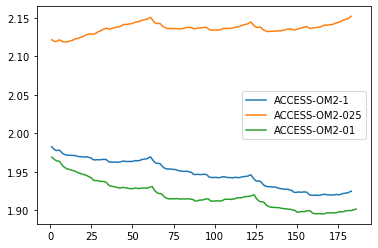

In [5]:
plt.plot(OHC_1deg[:,0], OHC_1deg[:,1], label='ACCESS-OM2-1')
plt.plot(OHC_025deg[:,0], OHC_025deg[:,1],label='ACCESS-OM2-025')
plt.plot(OHC_01deg[:,0], OHC_01deg[:,1],label='ACCESS-OM2-01'); plt.legend()
# Wall time: 14.7 s

### Next up, calculate the anomalies for three cases
remove
- trend over last three cycles
- trend over last two cycles
- trend over last cycle

CPU times: user 1.81 s, sys: 131 ms, total: 1.94 s
Wall time: 1.9 s


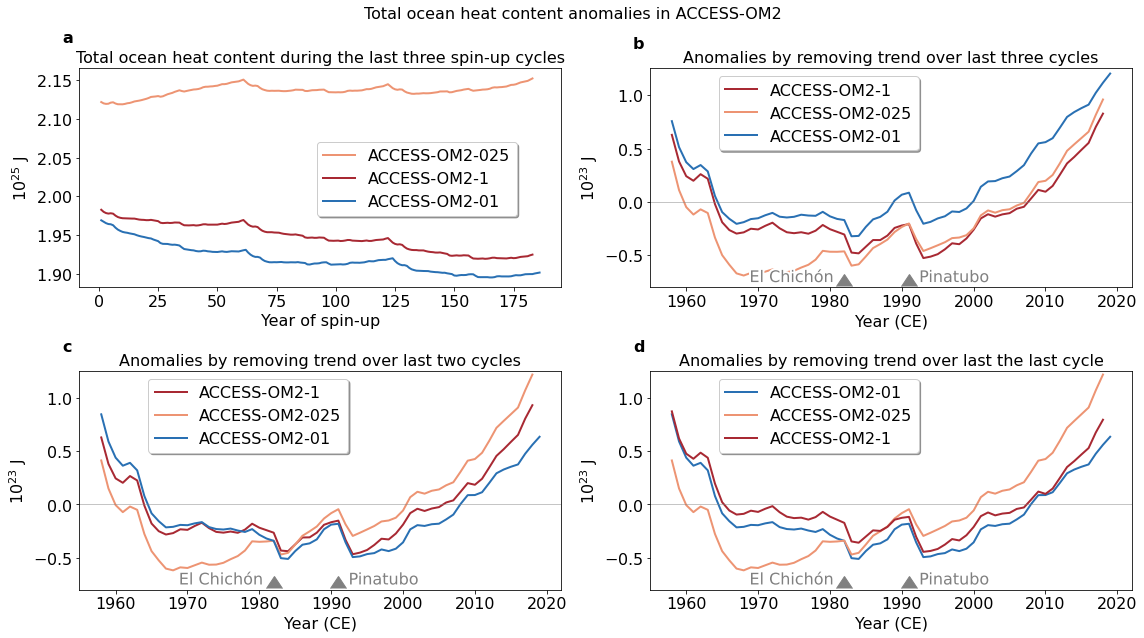

In [6]:
%%time
time_axis = np.linspace(1958,2018,61)
time_axis2 = np.linspace(1958,2019,62)

def fancy_plot(axes_nr, suffix, panel_label):
    plt.title('Anomalies by removing trend over last '+suffix, fontsize=16)
    # ticklabel  size
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    axes_nr.yaxis.offsetText.set_fontsize(16)
    axes_nr.yaxis.major.formatter._useMathText = True # use scientific notation
    axes_nr.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)
    plt.ylim([-.8,1.25])
    plt.locator_params(axis='y', nbins=6)
    axes_nr.text(-.035, 1.09, panel_label, transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    # plot volcano markers
    plt.plot(1982, -.67, marker=6, markersize=16, color = 'grey')
    plt.plot(1991, -.67, marker=6, markersize=16, color = 'grey')
    # # # add fancy label for volcanoes
    txt = plt.text(1982, -.75, 'El Chichón  ', color = 'grey', fontsize = 16, horizontalalignment = 'right')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])    
    txt = plt.text(1991, -.75, '  Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'left')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    plt.ylabel('10$^{23}$ J', fontsize=16); plt.xlabel('Year', fontsize=16)
    plt.xlabel('Year (CE)', fontsize=16)
    axes_nr.legend(loc='upper center', bbox_to_anchor=(.35, 1), fancybox=True, shadow=True, ncol=1, fontsize=16)

# initialise figure
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios = [1,1]) 

# -------------------- full time series -------------------- #
ax1 = plt.subplot(gs[0,0])
plt.plot(OHC_025deg[:,0], OHC_025deg[:,1],label='ACCESS-OM2-025', c=rotblau[6], linewidth=2)
plt.plot(OHC_1deg[:,0], OHC_1deg[:,1], label='ACCESS-OM2-1', c=rotblau[3], linewidth=2)
plt.plot(OHC_01deg[:,0], OHC_01deg[:,1],label='ACCESS-OM2-01', c=rotblau[17], linewidth=2)

plt.title('Total ocean heat content during the last three spin-up cycles', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation
plt.locator_params(axis='y', nbins=6)
ax1.text(-.035, 1.12, 'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
plt.ylabel('10$^{25}$ J', fontsize=16); plt.xlabel('Year of spin-up', fontsize=16)
ax1.legend(loc='upper center', bbox_to_anchor=(.7, .7), fancybox=True, shadow=True, ncol=1, fontsize=16)


# ---------------------------------------------------------------------- #

# -------------------- trend over last three cycles -------------------- #
for f in range(3): # loop over the three model runs
    if f == 0: data = OHC_1deg
    if f == 1: data = OHC_025deg
    if f == 2: data = OHC_01deg
    
    z1 = np.polyfit(data[:,0], data[:,1], 1); p1 = np.poly1d(z1) # fit a 1st degree polynomial to the last three cycles
    data = (data[:,1] - p1(data[:,0])) # calculate anomalies by removing the linear trend over the last cycle
                                       # and also remove the 1972-1981 baseline
    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data


    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data
ax1 = plt.subplot(gs[0,1])
plt.plot(time_axis,  (OHCa_1deg[-61:]*1e2)  , label='ACCESS-OM2-1', c=rotblau[3], linewidth=2)
plt.plot(time_axis,  (OHCa_025deg[-61:]*1e2), label='ACCESS-OM2-025', c=rotblau[6], linewidth=2)
plt.plot(time_axis2, (OHCa_01deg[-62:]*1e2) , label='ACCESS-OM2-01', c=rotblau[17], linewidth=2); fancy_plot(ax1, 'three cycles', 'b')
# ---------------------------------------------------------------------- #

# --------------------- trend over last two cycles --------------------- #
for f in range(3): # loop over the three model runs
    if f == 0: data = OHC_1deg[-122:,:]
    if f == 1: data = OHC_025deg[-122:,:]
    if f == 2: data = OHC_01deg[-124:,:]
    
    z1 = np.polyfit(data[:,0], data[:,1], 1); p1 = np.poly1d(z1) # fit a 1st degree polynomial to the last three cycles
    data = (data[:,1] - p1(data[:,0])) # calculate anomalies by removing the linear trend over the last cycle

    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data
ax1 = plt.subplot(gs[1,0])
plt.plot(time_axis, OHCa_1deg[-61:]*1e2  , label='ACCESS-OM2-1', c=rotblau[3], linewidth=2)
plt.plot(time_axis, OHCa_025deg[-61:]*1e2, label='ACCESS-OM2-025', c=rotblau[6], linewidth=2)
plt.plot(time_axis2, OHCa_01deg[-62:]*1e2 , label='ACCESS-OM2-01', c=rotblau[17], linewidth=2); fancy_plot(ax1, 'two cycles', 'c')
# ---------------------------------------------------------------------- #

# ----------------------- trend over last cycle ------------------------ #
for f in range(1): # loop over the three model runs
    if f == 0: data = OHC_1deg[-61:,:]
    if f == 1: data = OHC_025deg[-61:,:]
    if f == 2: data = OHC_01deg[-62:,:]
   
    z1 = np.polyfit(data[:,0], data[:,1], 1); p1 = np.poly1d(z1) # fit a 1st degree polynomial to the last three cycles
    data = (data[:,1] - p1(data[:,0])) # calculate anomalies by removing the linear trend over the last cycle

    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data
ax1 = plt.subplot(gs[1,1])
plt.plot(time_axis2, OHCa_01deg[-62:]*1e2 , label='ACCESS-OM2-01', c=rotblau[17], linewidth=2) 
plt.plot(time_axis, OHCa_025deg[-61:]*1e2, label='ACCESS-OM2-025', c=rotblau[6], linewidth=2)
plt.plot(time_axis, OHCa_1deg[-61:]*1e2  , label='ACCESS-OM2-1', c=rotblau[3], linewidth=2); fancy_plot(ax1, 'the last cycle', 'd')

plt.suptitle('Total ocean heat content anomalies in ACCESS-OM2', fontsize=16)  
    
# # reference lines for volcano eruption
# ax1.axvline(24, color='grey'); ax1.axvline(33, color='grey')


# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'OHC_time_series_last_spin-up_all_three_configurations', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Wall time: 2.15 s

### Only two panels for the Supporting Info figure

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


CPU times: user 1.18 s, sys: 113 ms, total: 1.29 s
Wall time: 1.23 s


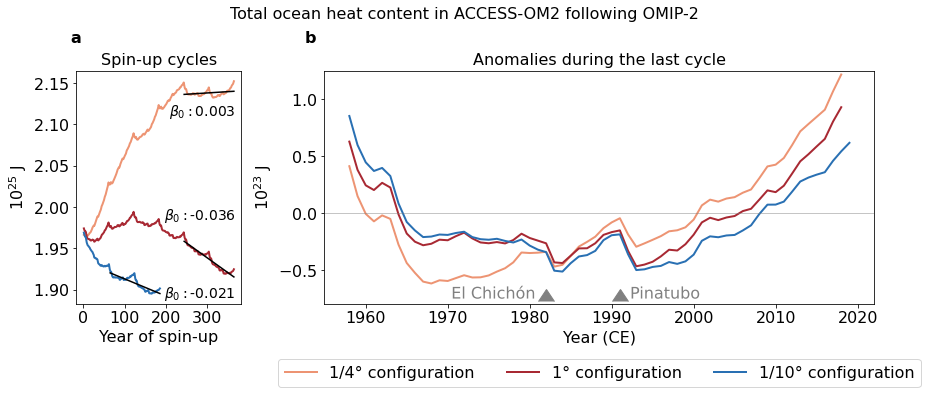

In [41]:
%%time
time_axis = np.linspace(1958,2018,61)
time_axis2 = np.linspace(1958,2019,62)

def fancy_plot(axes_nr, suffix, panel_label):
    plt.title('Anomalies during the last cycle', fontsize=16)
    # ticklabel  size
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    axes_nr.yaxis.offsetText.set_fontsize(16)
    axes_nr.yaxis.major.formatter._useMathText = True # use scientific notation
    axes_nr.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9)
    plt.ylim([-.8,1.25])
    plt.locator_params(axis='y', nbins=6)
    axes_nr.text(-.035, 1.12, panel_label, transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    # plot volcano markers
    plt.plot(1982, -.67, marker=6, markersize=16, color = 'grey')
    plt.plot(1991, -.67, marker=6, markersize=16, color = 'grey')
    # # # add fancy label for volcanoes
    txt = plt.text(1982, -.75, 'El Chichón  ', color = 'grey', fontsize = 16, horizontalalignment = 'right')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])    
    txt = plt.text(1991, -.75, '  Pinatubo', color = 'grey', fontsize = 16, horizontalalignment = 'left')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    plt.ylabel('10$^{23}$ J', fontsize=16); plt.xlabel('Year', fontsize=16)
    plt.xlabel('Year (CE)', fontsize=16)
    # axes_nr.legend(loc='upper center', bbox_to_anchor=(.35, 1), fancybox=True, shadow=True, ncol=1, fontsize=16)

# initialise figure
fig = plt.figure(figsize=(13, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios = [.3,1]) 

# -------------------- full time series -------------------- #
ax1 = plt.subplot(gs[0,0])
                                                   # remove the global mean as well for a better analysis
plt.plot(OHC_025deg_full[:,0], OHC_025deg_full[:,1],label='1/4° configuration', c=rotblau[6], linewidth=2)
plt.plot(OHC_1deg_full[:,0], OHC_1deg_full[:,1], label='1° configuration', c=rotblau[3], linewidth=2)
plt.plot(OHC_01deg[:,0], OHC_01deg[:,1],label='1/10° configuration', c=rotblau[17], linewidth=2)

plt.title('Spin-up cycles', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16)
ax1.yaxis.major.formatter._useMathText = True # use scientific notation
plt.locator_params(axis='y', nbins=6)
ax1.text(-.035, 1.12, 'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
plt.ylabel('10$^{25}$ J', fontsize=16); plt.xlabel('Year of spin-up', fontsize=16)
# ax1.legend(fontsize=16)

# adding the trend lines over the last two cycles for the three time series

z1 = np.polyfit(OHC_025deg_full[-122:,0], OHC_025deg_full[-122:,1], 1); p1 = np.poly1d(z1) 
plt.plot(OHC_025deg_full[-122:,0],p1(OHC_025deg_full[-122:,0]), color='k')
plt.text(370,2.11,r'$\beta_0:$'+str(np.round(z1[0]*100,3)), fontsize=14, ha = 'right') # units in 1e25 J century$^{-1}$
# ---
z1 = np.polyfit(OHC_1deg_full[-122:,0], OHC_1deg_full[-122:,1], 1); p1 = np.poly1d(z1) 
plt.plot(OHC_1deg_full[-122:,0],p1(OHC_1deg_full[-122:,0]), color='k')
plt.text(370,1.985,r'$\beta_0:$'+str(np.round(z1[0]*100,3)), fontsize=14, ha = 'right')
# ---
z1 = np.polyfit(OHC_01deg[-122:,0], OHC_01deg[-122:,1], 1); p1 = np.poly1d(z1) 
plt.plot(OHC_01deg[-122:,0],p1(OHC_01deg[-122:,0]), color='k')
plt.text(370,1.89,r'$\beta_0:$'+str(np.round(z1[0]*100,3)), fontsize=14, ha = 'right')

# ---------------------------------------------------------------------- #

# -------------------- trend over last three cycles -------------------- #
for f in range(3): # loop over the three model runs
    if f == 0: data = OHC_1deg
    if f == 1: data = OHC_025deg
    if f == 2: data = OHC_01deg
    
    z1 = np.polyfit(data[-122:,0], data[-122:,1], 1); p1 = np.poly1d(z1) # fit a 1st degree polynomial to the last two cycles
    data = (data[:,1] - p1(data[:,0])) # calculate anomalies by removing the linear trend over the last two cycles
    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data


    if f == 0: OHCa_1deg = data
    if f == 1: OHCa_025deg = data
    if f == 2: OHCa_01deg = data
ax1 = plt.subplot(gs[0,1])
plt.plot(time_axis,  (OHCa_025deg[-61:]*1e2), label='1/4° configuration', c=rotblau[6], linewidth=2)
plt.plot(time_axis,  (OHCa_1deg[-61:]*1e2)  , label='1° configuration', c=rotblau[3], linewidth=2)
plt.plot(time_axis2, (OHCa_01deg[-62:]*1e2) , label='1/10° configuration', c=rotblau[17], linewidth=2); fancy_plot(ax1, 'three cycles', 'b')

# ax1.hlines(1,1970,1980, linewidth=2, color='k', label='Linear trend last two cycles')
# 
# Put a legend below current axis
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=16)
# ---------------------------------------------------------------------- #

plt.suptitle('Total ocean heat content in ACCESS-OM2 following OMIP-2', fontsize=16)  

# --- saving as 300 dpi .PNG image in specified folder ------------------------
plt.savefig(save + 'OHC_time_series_last_spin-up_all_three_configurations_two_panels', dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
# %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Wall time: 2.15 s

In [8]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #